In [1]:
import torch
import sys
sys.path.append("/home/hul/hul/MADFT-NN/src")
sys.path.append("/home/hul/hul/LightAIMD/src/python")

from madftnn.dataset.dataset_unified import HamiltonianDataset_qhnet_clean, LmdbDataset,get_data_defult_config
from madftnn.utility.pyscf import get_pyscf_obj_from_dataset, get_homo_lumo_from_h, get_energy_from_h

from madftnn.training.module import *
from madftnn.utility.pyscf import *

data = LmdbDataset("/data/used_data/pubchem_20230831_processed/data.0000.lmdb",
            data_name='pubchem',
            enable_hami = True,
            old_blockbuild = False,
            basis = "def2-tzvp",
            remove_atomref_energy = True,
            remove_init=True)

/home/hul/conda/envs/madft_nn_torch210/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hul/conda/envs/madft_nn_torch210/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


# 不划分 整个矩阵施加一样的noise

In [10]:
index = 0
pos = data[index]['pos']
atomic_numbers = data[index]['atomic_numbers']
f_hi = data[index]['fock']

mol, mf,factory = get_pyscf_obj_from_dataset(pos, atomic_numbers.reshape(-1), basis="def2-tzvp", gpu=True)
dm0 = mf.init_guess_by_minao()
init_h = mf.get_fock(dm=dm0)
f_hi = f_hi/HATREE_TO_KCAL + init_h
E = get_energy_from_h(mf, f_hi)
E *= HATREE_TO_KCAL
E

-819842.7423301487

In [ ]:
import numpy as np

def get_mae_uni(index, mean, data):
    pos = data[index]['pos']
    atomic_numbers = data[index]['atomic_numbers']
    f_hi = data[index]['fock']

    mol, mf, factory = get_pyscf_obj_from_dataset(pos, atomic_numbers.reshape(-1), basis="def2-tzvp", gpu=True)
    dm0 = mf.init_guess_by_minao()
    init_h = mf.get_fock(dm=dm0)

    n = f_hi.shape[0]

    f_hi = f_hi + mean * f_hi
    f_hi = f_hi/HATREE_TO_KCAL + init_h
    Ep = get_energy_from_h(mf, f_hi)
    Ep *= HATREE_TO_KCAL

    E = data[index]['pyscf_energy']
    MAE = np.abs(E-Ep)
    print(E,Ep,E-Ep)
    if factory is not None:factory.free_resources()
    return MAE.item()

In [45]:
import numpy as np
N = 5
error_list = [0,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.2,0.5,1,2]
result2 = np.zeros((N, len(error_list)))
for i in range(N):
    for j,mean in enumerate(error_list):
        result2[i,j] = get_mae_uni(i*100, mean, data)
        


[[-819842.75]] -819842.7423301504 [[0.]]
[[-819842.75]] -819842.7423300346 [[0.]]
[[-819842.75]] -819842.7423291637 [[0.]]
[[-819842.75]] -819842.742327084 [[0.]]
[[-819842.75]] -819842.742271454 [[0.]]
[[-819842.75]] -819842.742104371 [[0.]]
[[-819842.75]] -819842.7368664499 [[0.]]
[[-819842.75]] -819842.7205682009 [[0.]]
[[-819842.75]] -819842.2006093569 [[-0.5625]]
[[-819842.75]] -819834.1136811057 [[-8.625]]
[[-819842.75]] -819789.288750027 [[-53.4375]]
[[-819842.75]] -819632.4850584146 [[-210.25]]
[[-819842.75]] -819030.6572719393 [[-812.0625]]
[[-852355.75]] -852355.7650533312 [[0.]]
[[-852355.75]] -852355.765053306 [[0.]]
[[-852355.75]] -852355.7650526349 [[0.]]
[[-852355.75]] -852355.7650504684 [[0.]]
[[-852355.75]] -852355.7649805214 [[0.]]
[[-852355.75]] -852355.7647613479 [[0.]]
[[-852355.75]] -852355.7577377281 [[0.]]
[[-852355.75]] -852355.7357753201 [[0.]]
[[-852355.75]] -852355.0313137103 [[-0.6875]]
[[-852355.75]] -852343.9367250903 [[-11.8125]]
[[-852355.75]] -852281.0

KeyboardInterrupt: 

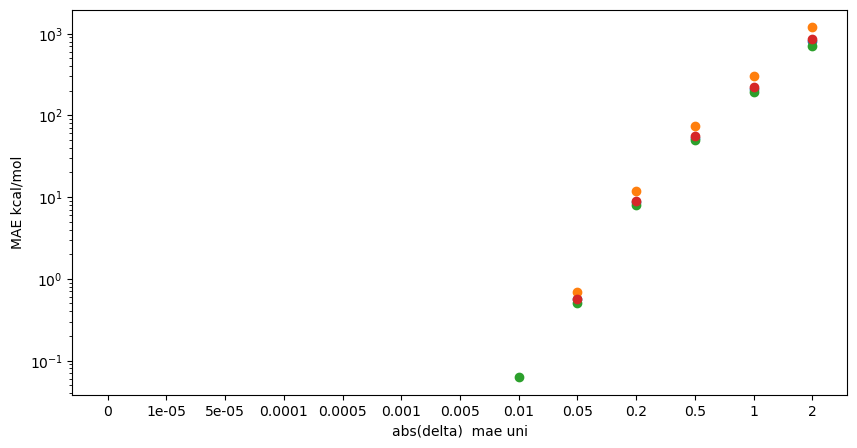

: 

In [49]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(N):
    plt.scatter([str(j)  for j in error_list], result2[i, :])
# plt.xticks(range(N), [j  for j in error_list])
plt.xlabel('abs(delta)  mae uni')
plt.ylabel('MAE kcal/mol')
plt.yscale('log')
plt.show()

In [46]:
import numpy as np

def get_mae_max(index, mean, data):
    pos = data[index]['pos']
    atomic_numbers = data[index]['atomic_numbers']
    f_hi = data[index]['fock']

    mol, mf, factory = get_pyscf_obj_from_dataset(pos, atomic_numbers.reshape(-1), basis="def2-tzvp", gpu=True)
    dm0 = mf.init_guess_by_minao()
    init_h = mf.get_fock(dm=dm0)

    n = f_hi.shape[0]
    delta = np.random.randn(n, n) * mean/2 + mean/2
    signs = np.random.choice([-1, 1], size=(n,n))
    delta *= signs
    delta = delta.clip(-1*mean,mean)
    f_hi = f_hi + delta * f_hi
    f_hi = f_hi/HATREE_TO_KCAL + init_h
    Ep = get_energy_from_h(mf, f_hi)
    Ep *= HATREE_TO_KCAL

    E = data[index]['pyscf_energy']
    MAE = np.abs(E-Ep)
    print(E,Ep,E-Ep)
    if factory is not None:factory.free_resources()
    return MAE.item()

In [47]:
import numpy as np
N = 5
error_list = [0,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.2,0.5,1,2]
result3 = np.zeros((N, len(error_list)))
for i in range(N):
    for j,mean in enumerate(error_list):
        result3[i,j] = get_mae_max(i*100, mean, data)
        


[[-819842.75]] -819842.7423301556 [[0.]]
[[-819842.75]] -819842.7420027069 [[0.]]
[[-819842.75]] -819842.739215329 [[0.]]
[[-819842.75]] -818071.9112311008 [[-1770.8125]]
[[-819842.75]] -815995.8354772677 [[-3846.9375]]
[[-819842.75]] -814845.8384574173 [[-4996.9375]]
[[-819842.75]] -793362.9103601942 [[-26479.812]]
[[-819842.75]] -774306.284133253 [[-45536.438]]
[[-819842.75]] -702587.0485281853 [[-117255.69]]
[[-819842.75]] -625825.1715968362 [[-194017.56]]
[[-819842.75]] -540226.5814613334 [[-279616.2]]
[[-819842.75]] -480601.25738873915 [[-339241.5]]
[[-819842.75]] -466879.4475143828 [[-352963.3]]
[[-852355.75]] -852355.7650533345 [[0.]]
[[-852355.75]] -852355.7646518571 [[0.]]
[[-852355.75]] -852355.7571193081 [[0.]]
[[-852355.75]] -852355.7170922095 [[-0.0625]]
[[-852355.75]] -849139.2279520863 [[-3216.5]]
[[-852355.75]] -840805.5891304673 [[-11550.1875]]
[[-852355.75]] -810035.1634681242 [[-42320.562]]
[[-852355.75]] -789175.3649971008 [[-63180.375]]
[[-852355.75]] -720009.90364

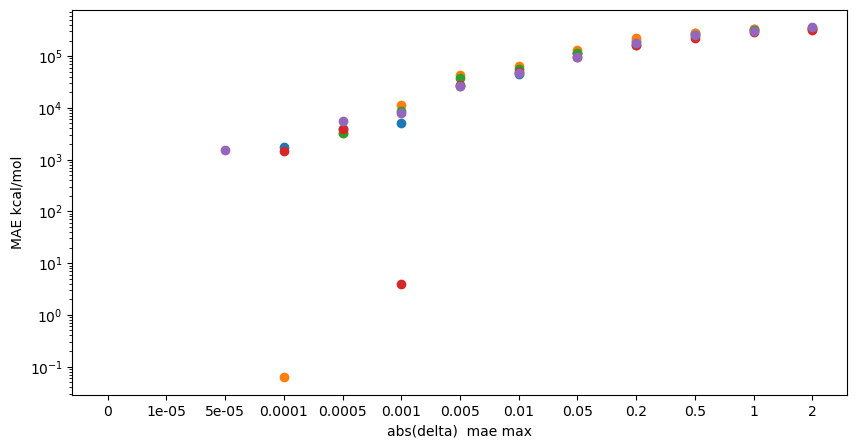

In [48]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(N):
    plt.scatter([str(j)  for j in error_list], result3[i, :])
# plt.xticks(range(N), [j  for j in error_list])
plt.xlabel('abs(delta)  mae max')
plt.ylabel('MAE kcal/mol')
plt.yscale('log')
plt.show()

In [2]:
import numpy as np

def get_mae(index, mean, data):
    pos = data[index]['pos']
    atomic_numbers = data[index]['atomic_numbers']
    f_hi = data[index]['fock']

    mol, mf, factory = get_pyscf_obj_from_dataset(pos, atomic_numbers.reshape(-1), basis="def2-tzvp", gpu=True)
    dm0 = mf.init_guess_by_minao()
    init_h = mf.get_fock(dm=dm0)

    n = f_hi.shape[0]
    delta = np.random.randn(n, n) * mean + mean
    signs = np.random.choice([-1, 1], size=(n,n))
    delta *= signs
    
    f_hi = f_hi + delta * f_hi
    f_hi = f_hi/HATREE_TO_KCAL + init_h
    Ep = get_energy_from_h(mf, f_hi)
    Ep *= HATREE_TO_KCAL

    E = data[index]['pyscf_energy']
    MAE = np.abs(E-Ep)
    print(E,Ep,E-Ep)
    if factory is not None:factory.free_resources()
    return MAE.item()

In [8]:
error_list = [0,0.00001,0.0001,0.001,0.01,0.05,0.2,0.5,1,2]
result = np.array(
    [[0.     ,0.0000000e+00, 6.2500000e-02, 1.4767125e+04,  75904.     , 155153.4375 , 256340.6875 ,347251.40625, 359417.15625, 424626. ],
          [0, 0.0000000e+00, 1.7138750e+03, 1.5948000e+04, 105690.25,205765,318166.2,382031.8,388354.53,618751.75]]
)

In [23]:
import numpy as np
N = 5
error_list = [0,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.2,0.5,1,2]
result = np.zeros((N, len(error_list)))
for i in range(N):
    for j,mean in enumerate(error_list):
        result[i,j] = get_mae(i*100, mean, data)
        


[[-1041885.06]] -1041885.0509168011 [[0.]]
[[-1041885.06]] -1041885.050179975 [[0.]]
[[-1041885.06]] -1041885.007633914 [[-0.0625]]
[[-1041885.06]] -1040052.7772908483 [[-1832.3125]]
[[-1041885.06]] -1033778.6767395542 [[-8106.375]]
[[-1041885.06]] -1023785.5529226463 [[-18099.5]]
[[-1041885.06]] -997304.2169432666 [[-44580.875]]
[[-1041885.06]] -966285.6231097672 [[-75599.44]]
[[-1041885.06]] -893924.4532849479 [[-147960.62]]
[[-1041885.06]] -798275.355021854 [[-243609.69]]
[[-1041885.06]] -718356.1776023824 [[-323528.88]]
[[-1041885.06]] -702771.4176386489 [[-339113.62]]
[[-1041885.06]] -599174.6758139738 [[-442710.38]]
[[-1018299.1]] -1018299.122240241 [[0.]]
[[-1018299.1]] -1018299.1213065754 [[0.]]
[[-1018299.1]] -1018299.0747047719 [[-0.0625]]
[[-1018299.1]] -1016776.0298421448 [[-1523.125]]
[[-1018299.1]] -1008449.523122098 [[-9849.625]]
[[-1018299.1]] -1004458.3710813826 [[-13840.75]]
[[-1018299.1]] -967846.061749778 [[-50453.062]]
[[-1018299.1]] -944580.0334331455 [[-73719.06]

IndexError: index 5 is out of bounds for axis 0 with size 5

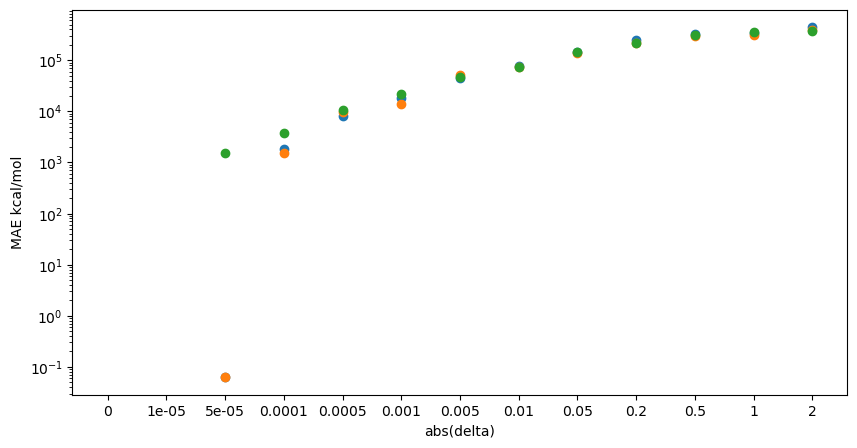

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.scatter([str(j)  for j in error_list], result[i+2, :])
# plt.xticks(range(N), [j  for j in error_list])
plt.xlabel('abs(delta)')
plt.ylabel('MAE kcal/mol')
plt.yscale('log')
plt.show()

# 划分大值区域 与 小值区域

In [137]:
f_hi[small_mask].shape

(727698,)

In [29]:
def get_mae_split(index, mean_small, mean_big, data, eps=1e-5):
    pos = data[index]['pos']
    atomic_numbers = data[index]['atomic_numbers']
    f_hi = data[index]['fock']

    small_mask = np.abs(f_hi) < eps
    big_mask = np.abs(f_hi) > eps

    fhi = f_hi.copy()
    
    n = fhi[small_mask].shape[0]
    delta = np.random.randn(n) * mean_small  + mean_small
    signs = np.random.choice([-1, 1], size=(n))
    delta *= signs
    fhi[small_mask] =  f_hi[small_mask] + delta * f_hi[small_mask]

    n = fhi[big_mask].shape[0]
    delta = np.random.randn(n) * mean_big + mean_big
    signs = np.random.choice([-1, 1], size=(n))
    delta *= signs
    fhi[big_mask] =  f_hi[big_mask] + delta * f_hi[big_mask]


    mol, mf,factory = get_pyscf_obj_from_dataset(pos, atomic_numbers.reshape(-1), basis="def2-tzvp", gpu=True)
    dm0 = mf.init_guess_by_minao()
    init_h = mf.get_fock(dm=dm0)


    
    fhi = fhi/HATREE_TO_KCAL + init_h
    Ep = get_energy_from_h(mf, fhi)
    Ep *= HATREE_TO_KCAL

    E = data[index]['pyscf_energy']
    MAE = np.abs(E-Ep)
    if factory is not None:factory.free_resources()

    return MAE.item()

In [30]:
N = 7
error_list = [0,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.2,0.5,1,2]

results = np.zeros((N,len(error_list),len(error_list)))
for idx in range(N):
    for i in range(len(error_list)):
        for j in range(len(error_list)):
            results[idx,i,j] = get_mae_split(idx, error_list[i], error_list[j], data)

KeyboardInterrupt: 

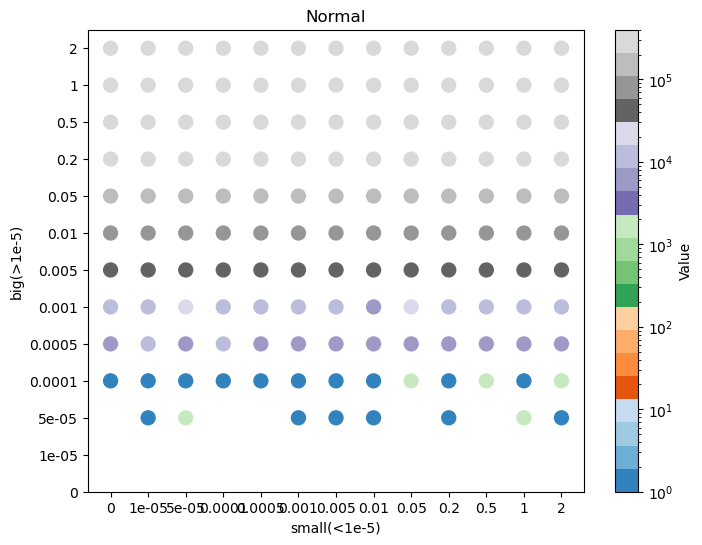

In [43]:
from matplotlib.colors import LogNorm
non_zero_indices = np.nonzero(results[0])
non_zero_values = results[0][non_zero_indices]
lerror = len(error_list)
plt.figure(figsize=(8, 6))
plt.scatter(non_zero_indices[0], non_zero_indices[1], c=non_zero_values, 
            norm = LogNorm(vmin=1, vmax=400000),
            cmap='tab20c', s=100)
plt.colorbar(label='Value')
plt.title('Normal')
plt.xlabel('small(<1e-5)')
plt.xticks(np.arange(0, lerror), labels=[j  for j in error_list])
plt.ylabel('big(>1e-5)')
plt.yticks(np.arange(0, lerror), labels=[j  for j in error_list])
plt.show()

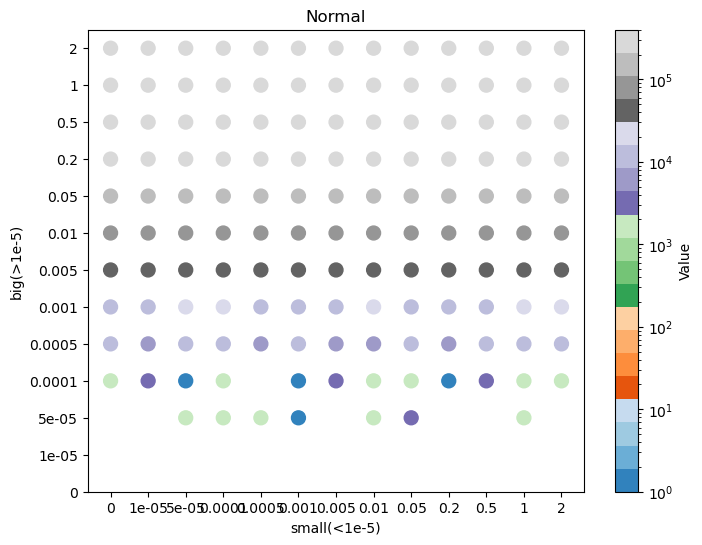

In [42]:
from matplotlib.colors import LogNorm
non_zero_indices = np.nonzero(results[1])
non_zero_values = results[1][non_zero_indices]
lerror = len(error_list)
plt.figure(figsize=(8, 6))
plt.scatter(non_zero_indices[0], non_zero_indices[1], c=non_zero_values, 
            norm = LogNorm(vmin=1, vmax=400000),
            cmap='tab20c', s=100)
plt.colorbar(label='Value')
plt.title('Normal')
plt.xlabel('small(<1e-5)')
plt.xticks(np.arange(0, lerror), labels=[j  for j in error_list])
plt.ylabel('big(>1e-5)')
plt.yticks(np.arange(0, lerror), labels=[j  for j in error_list])
plt.show()

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.plot([j * 0.2 + 0.2 for j in range(N)], result[i, :])

plt.xlabel('abs(delta)')
plt.ylabel('MAE')
plt.show()

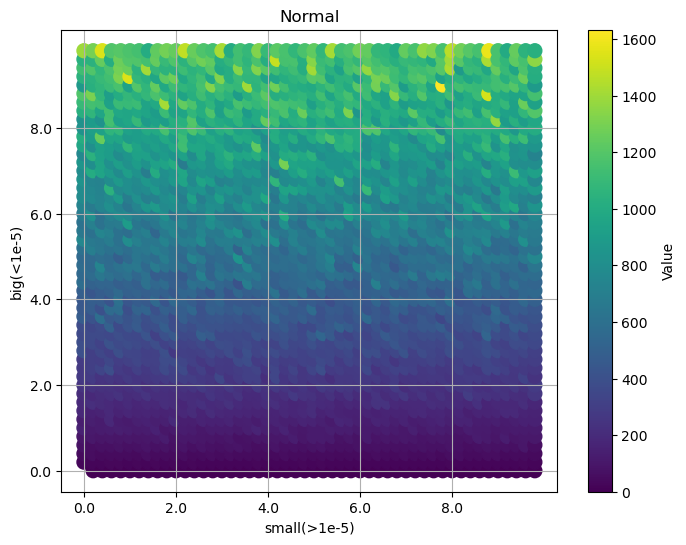

In [100]:
non_zero_indices = np.nonzero(results)
non_zero_values = results[non_zero_indices]

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(non_zero_indices[0], non_zero_indices[1], c=non_zero_values, cmap='viridis', s=100)
plt.colorbar(label='Value')
plt.title('Normal')
plt.xlabel('small(>1e-5)')
plt.xticks(np.arange(0, N, 10), labels=[j * 0.2  for j in range(0, N, 10)])
plt.ylabel('big(<1e-5)')
plt.yticks(np.arange(0, N, 10), labels=[j * 0.2  for j in range(0, N, 10)])
plt.grid(True)
plt.show()

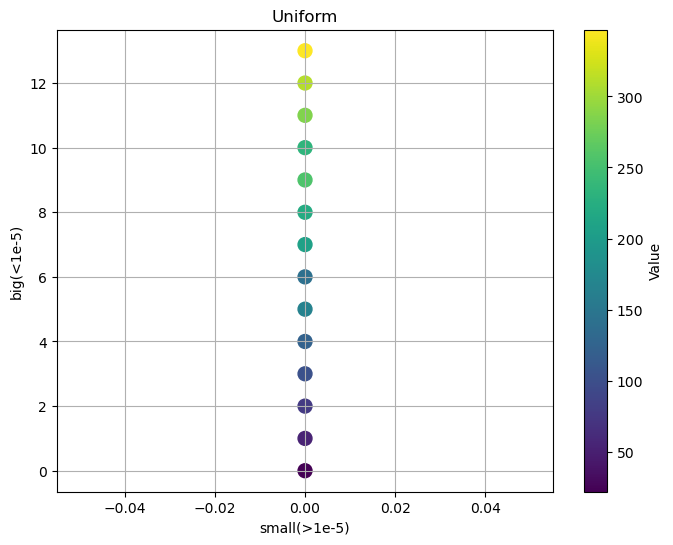

In [92]:
non_zero_indices = np.nonzero(result)
non_zero_values = result[non_zero_indices]

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(non_zero_indices[0], non_zero_indices[1], c=non_zero_values, cmap='viridis', s=100)
plt.colorbar(label='Value')
plt.title('Uniform')
plt.xlabel('small(>1e-5)')
plt.ylabel('big(<1e-5)')
plt.grid(True)
plt.show()

In [ ]:
index=0
eps = 1e-5

H = torch.tensor(data[index]['fock'])
O = torch.tensor(data[index]['s1e'])
A = torch.tensor(data[index]['atomic_numbers'])

_, _, Ep, _, _ = \
    eigen_solver(
        H.unsqueeze(0) * 100,
        O.unsqueeze(0) * 100,
        A,
        torch.linalg.eigh,
        'naive',
    )

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.plot([j * 0.2 + 0.2 for j in range(N)], result[i, :])

plt.xlabel('abs(delta)')
plt.ylabel('MAE')
plt.show()

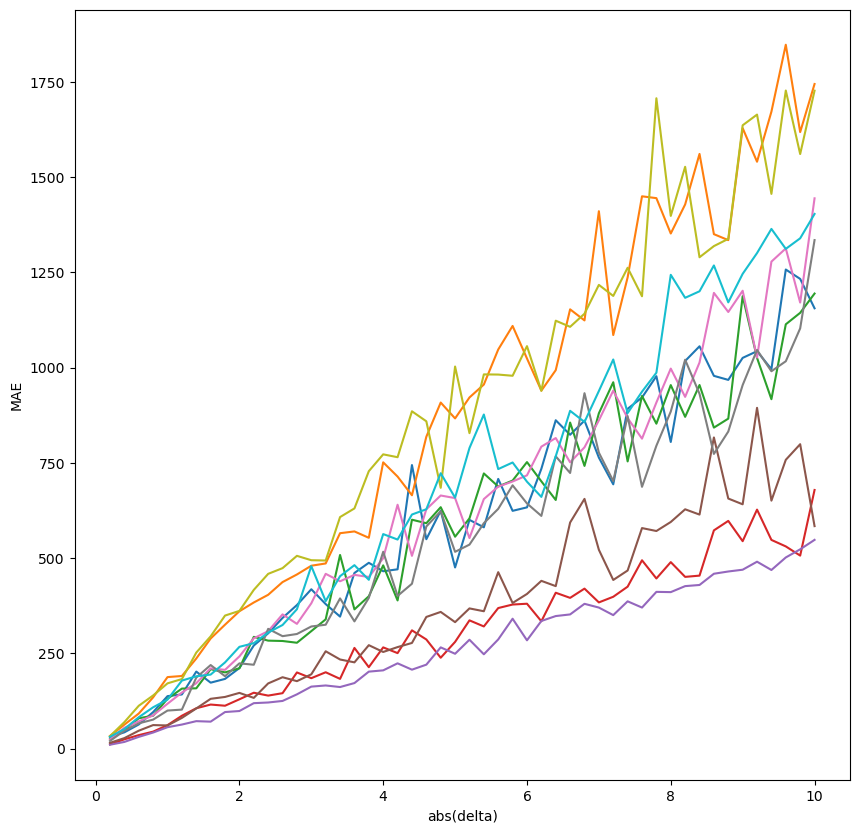

In [69]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.plot([j * 0.2 + 0.2 for j in range(N)], result[i, :])

plt.xlabel('abs(delta)')
plt.ylabel('MAE')
plt.show()

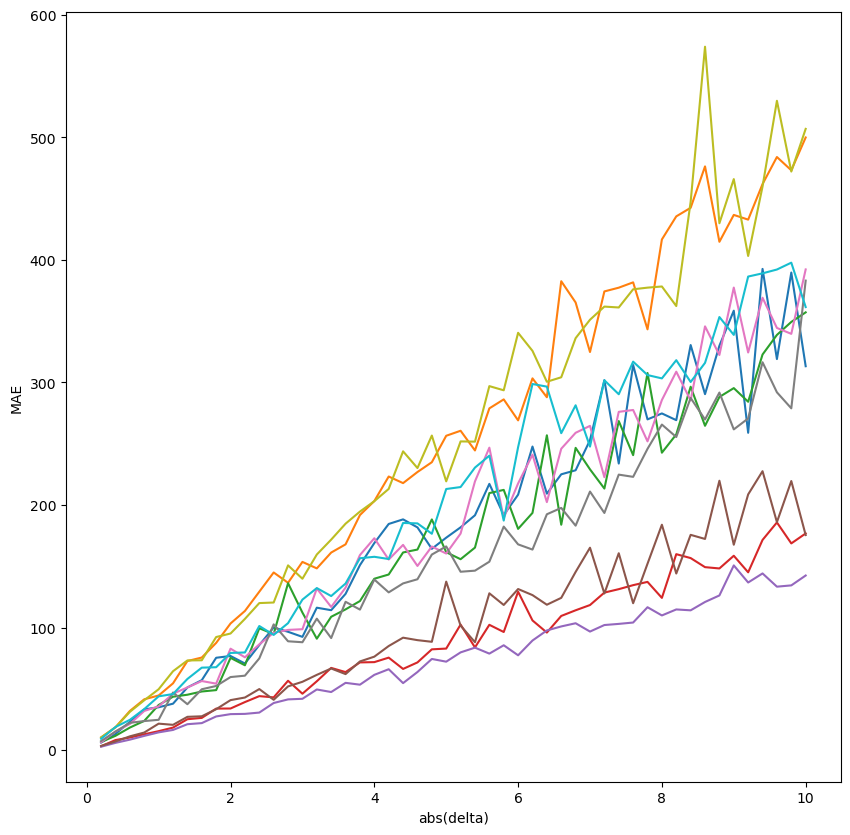

In [51]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.plot([j * 0.2 + 0.2 for j in range(N)], result[i, :])

plt.xlabel('abs(delta)')
plt.ylabel('MAE')
plt.show()

In [ ]:
from madftnn.training.module import *
batch_size = batch_data['energy'].shape[0]
energy = batch_data['energy']
full_hami = batch_data['pred_hamiltonian']
hami_energy = torch.zeros_like(energy)
for i in range(1):
    start , end = batch_data['ptr'][i],batch_data['ptr'][i+1]
    pos = batch_data['pos'][start:end].detach().cpu().numpy()
    atomic_numbers = batch_data['atomic_numbers'][start:end].detach().cpu().numpy()
    mol, mf = get_pyscf_obj_from_dataset(pos,atomic_numbers, basis="def2-tzvp", gpu=True)
    dm0 = mf.init_guess_by_minao()
    init_h = mf.get_fock(dm=dm0)

    f_hi = full_hami[i].detach().cpu().numpy()/HATREE_TO_KCAL+init_h
    mo_energy, mo_coeff =mf.eig(f_hi,mf.get_ovlp())

    hami_energy[i] = get_energy_from_h(mf, f_hi)
    hami_energy[i] *= HATREE_TO_KCAL